<a href="https://colab.research.google.com/github/supsi-dacd-isaac/TeachDecisionMakingUncertainty/blob/main/L12/Q_Learning_with_Linear_Function_Approximation_solutions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Q-learning with linear function approximations
*Partially based on [this notebook](https://github.com/dennybritz/reinforcement-learning/blob/master/FA/Q-Learning%20with%20Value%20Function%20Approximation%20Solution.ipynb)*

### Approximator
In this exercise we'll apply q-learning with a linear regressor for extrapolating values of $q(s, a)$:
$$\hat{q}(s, a) = g_{\theta,a}(s) = \phi(s) \theta_a$$

where $\phi(s): \mathbb{R}^{n_s}\rightarrow \mathbb{R}^{ f}$ is a feature map taking states and returning a set of $f$ features.
Since the learning is done *on the fly*, that is, as the agent collects experience from the environment, we'll use an *online linear regressor* using stochastic gradient descent to update the parameter vector $\theta_a$, `SGDRegressor`.
### Feature map

We will use [random Fourier features](https://people.eecs.berkeley.edu/~brecht/papers/07.rah.rec.nips.pdf) to create $\phi(s)$: the inputs are projected onto a random oriented plane, and passed to a trigonometric function:
$$\phi_\omega(s)=\sqrt{2} \cos \left(\boldsymbol{\omega}^{\top} s+b\right)$$  
where $\boldsymbol{\omega}$ is sampled from a Gaussian disribution.


### The Mountain Car environment

The Mountain Car MDP is a deterministic MDP that consists of a car placed stochastically at the bottom of a sinusoidal valley, with the only possible actions being the accelerations that can be applied to the car in either direction. The goal of the MDP is to strategically accelerate the car to reach the goal state on top of the right hill



<img src="https://gymnasium.farama.org/_images/mountain_car.gif" width="200">

**Observation space**
<center>

| Num | Observation                          | Min   | Max   | Unit        |
|-----|--------------------------------------|--------|--------|-------------|
| 0   | Position of the car along the x-axis | -1.2   | 0.6    | position (m)|
| 1   | Velocity of the car                  | -0.07  | 0.07   | velocity (v)|

</center>

**Action space**
<center>

| Num | Action                          | Values   | Unit        |
|-----|--------------------------------------|--------|-------------|
| 0   | Acceleration along the x-axis | [-1, 0, 1]    |  (m/s²)|

</center>



**Transition dynamics**
$$v_{t+1} = v_t + (a - 1) * force - cos(3 * x_t) * g$$

$$x_{t+1} = x_t + v_{t+1}$$

**Reward**

The goal is to reach the flag placed on top of the right hill as quickly as possible, as such the agent is penalised with a reward of -1 for each timestep.


In [ ]:
%%capture
!pip install wget
!pip install numpy==1.23.5

<font color='red'>**RESTATR THE SESSION AFTER THE EXECUTION OF THE PREVIOUS CELL**</font>

In [ ]:
#@title Imports
%matplotlib inline

import gym
import itertools
import numpy as np
import sys
import sklearn.pipeline
import sklearn.preprocessing

import matplotlib.pyplot as plt
import matplotlib
from matplotlib import animation
from matplotlib.animation import FuncAnimation
from matplotlib.colors import Normalize
from matplotlib.colors import ListedColormap
from IPython.display import HTML




if "../" not in sys.path:
  sys.path.append("../")

import wget
wget.download('https://github.com/dennybritz/reinforcement-learning/raw/refs/heads/master/lib/plotting.py')

import plotting
from sklearn.linear_model import SGDRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.kernel_approximation import RBFSampler

matplotlib.style.use('ggplot')

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
np.random.seed(0)

## Create Environment

In [ ]:
env = gym.make("MountainCar-v0", max_episode_steps=500, render_mode="rgb_array")

# Feature map
The following code creates the feature map using `RBFSampler`.

In [ ]:
observation_examples = np.array([env.observation_space.sample() for x in range(10000)])
scaler = sklearn.preprocessing.StandardScaler()


featurizer = sklearn.pipeline.FeatureUnion([
        ("rbf1", RBFSampler(gamma=5.0, n_components=120)),
        ("rbf2", RBFSampler(gamma=2.0, n_components=120)),
        ("rbf3", RBFSampler(gamma=1.0, n_components=120)),
        ("rbf4", RBFSampler(gamma=0.5, n_components=120)),
        ("rbf5", RBFSampler(gamma=3.0, n_components=120))
        ])

featurizer.fit(scaler.fit_transform(observation_examples))


FeatureUnion(transformer_list=[('rbf1',
                                RBFSampler(gamma=5.0, n_components=120)),
                               ('rbf2',
                                RBFSampler(gamma=2.0, n_components=120)),
                               ('rbf3', RBFSampler(n_components=120)),
                               ('rbf4',
                                RBFSampler(gamma=0.5, n_components=120)),
                               ('rbf5',
                                RBFSampler(gamma=3.0, n_components=120))])

the following plots visualize some components of the feature map $$\phi_\omega(\mathbf{x})=\sqrt{2} \cos \left(\boldsymbol{\omega}^{\top} \mathbf{x}+b\right)$$
in the  

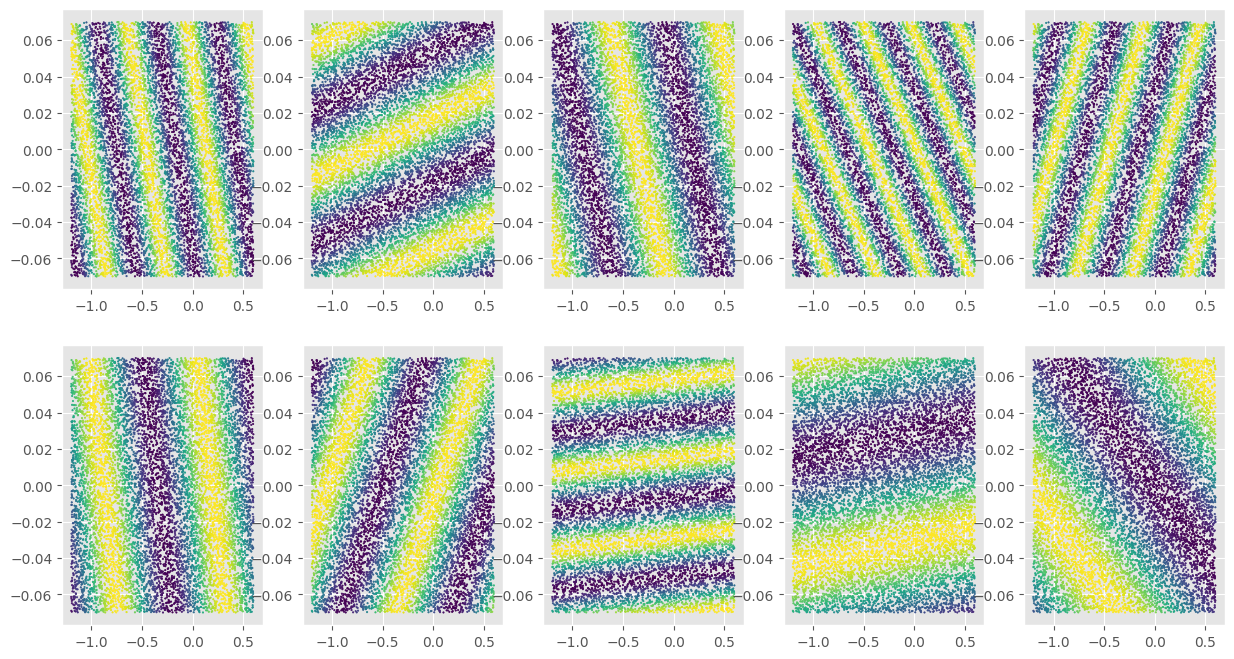

In [ ]:
features = featurizer.transform(scaler.transform(observation_examples))
fig, ax = plt.subplots(2, 5, figsize=(15, 8))
for i, a in zip(range(10), ax.ravel()):
  a.scatter(*observation_examples.T, s=1, c=features[:, i])

###❓ Can you describe what the `__init__` function of this method does?

In [ ]:
class Function_Approximator():

    def __init__(self):
        self.models = []
        for i in range(env.action_space.n):
            model = SGDRegressor(learning_rate="constant", eta0=1e-1)
            model.partial_fit([self.featurize_state(env.reset())], [0])
            self.models.append(model)


    def featurize_state(self, state):
        scaled = scaler.transform([state])
        features = featurizer.transform(scaled)
        return features[0]


    def predict(self, s, a=None):

        state_features = self.featurize_state(s)
        if not a:
            return np.array([m.predict([state_features])[0] for m in self.models])
        else:
            return self.models[a].predict([state_features])[0]

    def update(self, s, a, y):

        features = self.featurize_state(s)
        self.models[a].partial_fit([features], [y])

### ❓ ✏ proove that the vector A generated by this $\epsilon$-greedy policy is a probability distribution (sum(A) =1).  

In [ ]:
def make_epsilon_greedy_policy(estimator, epsilon, nA):

    def policy_fn(observation):
        A = np.ones(nA, dtype=float) * epsilon / nA
        q_values = estimator.predict(observation)
        best_action = np.argmax(q_values)
        A[best_action] += (1.0 - epsilon)
        return A
    return policy_fn

The following code predicts the q values and the optimal action on the states' space.

In [ ]:
def landscapes(env, estimator, num_tiles = 20):
  x = np.linspace(env.observation_space.low[0], env.observation_space.high[0], num=num_tiles)
  y = np.linspace(env.observation_space.low[1], env.observation_space.high[1], num=num_tiles)
  X, Y = np.meshgrid(x, y)
  O = np.apply_along_axis(lambda _: -np.max(estimator.predict(_)), 2, np.dstack([X, Y]))
  P = np.apply_along_axis(lambda _: np.argmax(estimator.predict(_)), 2, np.dstack([X, Y]))

  return (X, Y, O, P)

### ❓ Describe what the following code does and complete the missing line

In [ ]:
from tqdm import tqdm
def q_learning(env, estimator, num_episodes, discount_factor=1.0, epsilon=0.1, epsilon_decay=1.0):

    stats = plotting.EpisodeStats(
        episode_lengths=np.zeros(num_episodes),
        episode_rewards=np.zeros(num_episodes))

    landscapes_tuples = []
    for i_episode in tqdm(range(num_episodes)):

        policy = make_epsilon_greedy_policy(estimator, epsilon * epsilon_decay**i_episode, env.action_space.n)
        state = env.reset()

        for t in itertools.count():

            action_probs = policy(state)
            action = np.random.choice(np.arange(len(action_probs)), p=action_probs)

            next_state, reward, end, _ = env.step(action)

            stats.episode_rewards[i_episode] += reward
            stats.episode_lengths[i_episode] = t

            q_values_next = estimator.predict(next_state)

            #### COMPLETE THIS
            td_target = reward + discount_factor * np.max(q_values_next)

            estimator.update(state, action, td_target)


            if end and i_episode%10 == 0:
              landscapes_tuples.append(landscapes(env, estimator))

            if end:
              print("\rStep {} @ Episode {}/{} ({})".format(t, i_episode + 1, num_episodes, reward))
              break

            state = next_state

    return stats, landscapes_tuples

In [ ]:
estimator = Function_Approximator()
stats, landscapes_tuples = q_learning(env, estimator, 150, epsilon=0.1, discount_factor=1)

  1%|          | 1/150 [00:14<37:09, 14.97s/it]

Step 499 @ Episode 1/150 (-1.0)


  1%|▏         | 2/150 [00:22<26:23, 10.70s/it]

Step 332 @ Episode 2/150 (-1.0)


  2%|▏         | 3/150 [00:25<17:27,  7.13s/it]

Step 203 @ Episode 3/150 (-1.0)


  3%|▎         | 4/150 [00:28<12:54,  5.30s/it]

Step 165 @ Episode 4/150 (-1.0)


  3%|▎         | 5/150 [00:29<09:35,  3.97s/it]

Step 153 @ Episode 5/150 (-1.0)


  4%|▍         | 6/150 [00:31<07:39,  3.19s/it]

Step 167 @ Episode 6/150 (-1.0)


  5%|▍         | 7/150 [00:33<06:35,  2.76s/it]

Step 185 @ Episode 7/150 (-1.0)


  5%|▌         | 8/150 [00:34<05:34,  2.36s/it]

Step 144 @ Episode 8/150 (-1.0)


  6%|▌         | 9/150 [00:36<05:14,  2.23s/it]

Step 190 @ Episode 9/150 (-1.0)


  7%|▋         | 10/150 [00:38<04:35,  1.97s/it]

Step 138 @ Episode 10/150 (-1.0)


  7%|▋         | 11/150 [00:42<06:05,  2.63s/it]

Step 150 @ Episode 11/150 (-1.0)


  8%|▊         | 12/150 [00:43<05:00,  2.18s/it]

Step 112 @ Episode 12/150 (-1.0)


  9%|▊         | 13/150 [00:44<04:34,  2.00s/it]

Step 157 @ Episode 13/150 (-1.0)


  9%|▉         | 14/150 [00:46<04:10,  1.84s/it]

Step 148 @ Episode 14/150 (-1.0)


 10%|█         | 15/150 [00:48<04:17,  1.91s/it]

Step 208 @ Episode 15/150 (-1.0)


 11%|█         | 16/150 [00:50<04:11,  1.88s/it]

Step 184 @ Episode 16/150 (-1.0)


 11%|█▏        | 17/150 [00:53<04:46,  2.15s/it]

Step 212 @ Episode 17/150 (-1.0)


 12%|█▏        | 18/150 [00:54<04:13,  1.92s/it]

Step 113 @ Episode 18/150 (-1.0)


 13%|█▎        | 19/150 [00:56<03:57,  1.81s/it]

Step 157 @ Episode 19/150 (-1.0)


 13%|█▎        | 20/150 [00:57<03:41,  1.70s/it]

Step 144 @ Episode 20/150 (-1.0)


 14%|█▍        | 21/150 [01:00<04:22,  2.04s/it]

Step 108 @ Episode 21/150 (-1.0)


 15%|█▍        | 22/150 [01:01<03:56,  1.85s/it]

Step 143 @ Episode 22/150 (-1.0)


 15%|█▌        | 23/150 [01:03<03:48,  1.80s/it]

Step 170 @ Episode 23/150 (-1.0)


 16%|█▌        | 24/150 [01:05<03:56,  1.88s/it]

Step 153 @ Episode 24/150 (-1.0)


 17%|█▋        | 25/150 [01:07<03:52,  1.86s/it]

Step 143 @ Episode 25/150 (-1.0)


 17%|█▋        | 26/150 [01:08<03:33,  1.72s/it]

Step 140 @ Episode 26/150 (-1.0)


 18%|█▊        | 27/150 [01:10<03:19,  1.62s/it]

Step 137 @ Episode 27/150 (-1.0)


 19%|█▊        | 28/150 [01:11<03:21,  1.65s/it]

Step 172 @ Episode 28/150 (-1.0)


 19%|█▉        | 29/150 [01:13<03:10,  1.58s/it]

Step 140 @ Episode 29/150 (-1.0)


 20%|██        | 30/150 [01:14<02:59,  1.50s/it]

Step 132 @ Episode 30/150 (-1.0)


 21%|██        | 31/150 [01:17<03:45,  1.89s/it]

Step 93 @ Episode 31/150 (-1.0)


 21%|██▏       | 32/150 [01:19<03:50,  1.95s/it]

Step 144 @ Episode 32/150 (-1.0)


 22%|██▏       | 33/150 [01:20<03:30,  1.80s/it]

Step 146 @ Episode 33/150 (-1.0)


 23%|██▎       | 34/150 [01:22<03:15,  1.69s/it]

Step 143 @ Episode 34/150 (-1.0)


 23%|██▎       | 35/150 [01:23<03:04,  1.60s/it]

Step 142 @ Episode 35/150 (-1.0)


 24%|██▍       | 36/150 [01:25<02:58,  1.57s/it]

Step 148 @ Episode 36/150 (-1.0)


 25%|██▍       | 37/150 [01:26<02:50,  1.51s/it]

Step 139 @ Episode 37/150 (-1.0)


 25%|██▌       | 38/150 [01:27<02:45,  1.48s/it]

Step 139 @ Episode 38/150 (-1.0)


 26%|██▌       | 39/150 [01:29<02:33,  1.39s/it]

Step 117 @ Episode 39/150 (-1.0)


 27%|██▋       | 40/150 [01:30<02:45,  1.51s/it]

Step 122 @ Episode 40/150 (-1.0)


 27%|██▋       | 41/150 [01:34<03:40,  2.02s/it]

Step 110 @ Episode 41/150 (-1.0)


 28%|██▊       | 42/150 [01:35<03:13,  1.80s/it]

Step 123 @ Episode 42/150 (-1.0)


 29%|██▊       | 43/150 [01:36<03:02,  1.70s/it]

Step 147 @ Episode 43/150 (-1.0)


 29%|██▉       | 44/150 [01:38<02:52,  1.63s/it]

Step 144 @ Episode 44/150 (-1.0)


 30%|███       | 45/150 [01:39<02:47,  1.60s/it]

Step 152 @ Episode 45/150 (-1.0)


 31%|███       | 46/150 [01:41<02:41,  1.56s/it]

Step 145 @ Episode 46/150 (-1.0)


 31%|███▏      | 47/150 [01:42<02:39,  1.55s/it]

Step 123 @ Episode 47/150 (-1.0)


 32%|███▏      | 48/150 [01:44<02:52,  1.69s/it]

Step 138 @ Episode 48/150 (-1.0)


 33%|███▎      | 49/150 [01:46<02:37,  1.56s/it]

Step 125 @ Episode 49/150 (-1.0)


 33%|███▎      | 50/150 [01:47<02:37,  1.57s/it]

Step 162 @ Episode 50/150 (-1.0)


 34%|███▍      | 51/150 [01:50<03:06,  1.88s/it]

Step 95 @ Episode 51/150 (-1.0)


 35%|███▍      | 52/150 [01:51<02:48,  1.72s/it]

Step 137 @ Episode 52/150 (-1.0)


 35%|███▌      | 53/150 [01:53<02:38,  1.64s/it]

Step 141 @ Episode 53/150 (-1.0)


 36%|███▌      | 54/150 [01:54<02:34,  1.61s/it]

Step 115 @ Episode 54/150 (-1.0)


 37%|███▋      | 55/150 [01:56<02:48,  1.77s/it]

Step 142 @ Episode 55/150 (-1.0)


 37%|███▋      | 56/150 [01:58<02:34,  1.64s/it]

Step 112 @ Episode 56/150 (-1.0)


 38%|███▊      | 57/150 [01:59<02:29,  1.61s/it]

Step 149 @ Episode 57/150 (-1.0)


 39%|███▊      | 58/150 [02:01<02:23,  1.56s/it]

Step 145 @ Episode 58/150 (-1.0)


 39%|███▉      | 59/150 [02:02<02:29,  1.64s/it]

Step 145 @ Episode 59/150 (-1.0)


 40%|████      | 60/150 [02:04<02:35,  1.73s/it]

Step 156 @ Episode 60/150 (-1.0)


 41%|████      | 61/150 [02:08<03:17,  2.21s/it]

Step 142 @ Episode 61/150 (-1.0)


 41%|████▏     | 62/150 [02:10<03:12,  2.19s/it]

Step 149 @ Episode 62/150 (-1.0)


 42%|████▏     | 63/150 [02:11<02:54,  2.00s/it]

Step 155 @ Episode 63/150 (-1.0)


 43%|████▎     | 64/150 [02:13<02:37,  1.83s/it]

Step 147 @ Episode 64/150 (-1.0)


 43%|████▎     | 65/150 [02:14<02:23,  1.69s/it]

Step 135 @ Episode 65/150 (-1.0)


 44%|████▍     | 66/150 [02:16<02:19,  1.66s/it]

Step 161 @ Episode 66/150 (-1.0)


 45%|████▍     | 67/150 [02:17<02:12,  1.59s/it]

Step 145 @ Episode 67/150 (-1.0)


 45%|████▌     | 68/150 [02:18<02:00,  1.47s/it]

Step 120 @ Episode 68/150 (-1.0)


 46%|████▌     | 69/150 [02:20<02:03,  1.52s/it]

Step 144 @ Episode 69/150 (-1.0)


 47%|████▋     | 70/150 [02:22<02:20,  1.76s/it]

Step 159 @ Episode 70/150 (-1.0)


 47%|████▋     | 71/150 [02:25<02:50,  2.16s/it]

Step 140 @ Episode 71/150 (-1.0)


 48%|████▊     | 72/150 [02:27<02:30,  1.92s/it]

Step 137 @ Episode 72/150 (-1.0)


 49%|████▊     | 73/150 [02:28<02:09,  1.68s/it]

Step 111 @ Episode 73/150 (-1.0)


 49%|████▉     | 74/150 [02:29<02:03,  1.63s/it]

Step 147 @ Episode 74/150 (-1.0)


 50%|█████     | 75/150 [02:31<01:58,  1.59s/it]

Step 149 @ Episode 75/150 (-1.0)


 51%|█████     | 76/150 [02:33<01:57,  1.59s/it]

Step 145 @ Episode 76/150 (-1.0)


 51%|█████▏    | 77/150 [02:35<02:11,  1.81s/it]

Step 153 @ Episode 77/150 (-1.0)


 52%|█████▏    | 78/150 [02:36<02:03,  1.71s/it]

Step 143 @ Episode 78/150 (-1.0)


 53%|█████▎    | 79/150 [02:38<01:52,  1.59s/it]

Step 130 @ Episode 79/150 (-1.0)


 53%|█████▎    | 80/150 [02:39<01:49,  1.56s/it]

Step 147 @ Episode 80/150 (-1.0)


 54%|█████▍    | 81/150 [02:43<02:25,  2.11s/it]

Step 160 @ Episode 81/150 (-1.0)


 55%|█████▍    | 82/150 [02:44<02:10,  1.92s/it]

Step 145 @ Episode 82/150 (-1.0)


 55%|█████▌    | 83/150 [02:46<02:05,  1.87s/it]

Step 143 @ Episode 83/150 (-1.0)


 56%|█████▌    | 84/150 [02:48<02:06,  1.92s/it]

Step 144 @ Episode 84/150 (-1.0)


 57%|█████▋    | 85/150 [02:49<01:53,  1.74s/it]

Step 134 @ Episode 85/150 (-1.0)


 57%|█████▋    | 86/150 [02:51<01:45,  1.65s/it]

Step 147 @ Episode 86/150 (-1.0)


 58%|█████▊    | 87/150 [02:52<01:32,  1.48s/it]

Step 107 @ Episode 87/150 (-1.0)


 59%|█████▊    | 88/150 [02:53<01:30,  1.46s/it]

Step 143 @ Episode 88/150 (-1.0)


 59%|█████▉    | 89/150 [02:54<01:23,  1.37s/it]

Step 112 @ Episode 89/150 (-1.0)


 60%|██████    | 90/150 [02:55<01:18,  1.31s/it]

Step 118 @ Episode 90/150 (-1.0)


 61%|██████    | 91/150 [02:59<01:56,  1.98s/it]

Step 154 @ Episode 91/150 (-1.0)


 61%|██████▏   | 92/150 [03:01<01:48,  1.87s/it]

Step 116 @ Episode 92/150 (-1.0)


 62%|██████▏   | 93/150 [03:02<01:34,  1.65s/it]

Step 113 @ Episode 93/150 (-1.0)


 63%|██████▎   | 94/150 [03:03<01:29,  1.61s/it]

Step 150 @ Episode 94/150 (-1.0)


 63%|██████▎   | 95/150 [03:04<01:21,  1.48s/it]

Step 120 @ Episode 95/150 (-1.0)


 64%|██████▍   | 96/150 [03:06<01:16,  1.41s/it]

Step 123 @ Episode 96/150 (-1.0)


 65%|██████▍   | 97/150 [03:07<01:15,  1.42s/it]

Step 145 @ Episode 97/150 (-1.0)


 65%|██████▌   | 98/150 [03:08<01:09,  1.33s/it]

Step 112 @ Episode 98/150 (-1.0)


 66%|██████▌   | 99/150 [03:10<01:09,  1.35s/it]

Step 141 @ Episode 99/150 (-1.0)


 67%|██████▋   | 100/150 [03:11<01:13,  1.47s/it]

Step 139 @ Episode 100/150 (-1.0)


 67%|██████▋   | 101/150 [03:15<01:39,  2.04s/it]

Step 111 @ Episode 101/150 (-1.0)


 68%|██████▊   | 102/150 [03:16<01:31,  1.91s/it]

Step 161 @ Episode 102/150 (-1.0)


 69%|██████▊   | 103/150 [03:18<01:22,  1.75s/it]

Step 138 @ Episode 103/150 (-1.0)


 69%|██████▉   | 104/150 [03:19<01:15,  1.63s/it]

Step 141 @ Episode 104/150 (-1.0)


 70%|███████   | 105/150 [03:20<01:09,  1.54s/it]

Step 132 @ Episode 105/150 (-1.0)


 71%|███████   | 106/150 [03:22<01:05,  1.49s/it]

Step 140 @ Episode 106/150 (-1.0)


 71%|███████▏  | 107/150 [03:23<00:59,  1.38s/it]

Step 113 @ Episode 107/150 (-1.0)


 72%|███████▏  | 108/150 [03:25<01:07,  1.60s/it]

Step 142 @ Episode 108/150 (-1.0)


 73%|███████▎  | 109/150 [03:27<01:07,  1.64s/it]

Step 147 @ Episode 109/150 (-1.0)


 73%|███████▎  | 110/150 [03:28<01:04,  1.61s/it]

Step 153 @ Episode 110/150 (-1.0)


 74%|███████▍  | 111/150 [03:31<01:19,  2.03s/it]

Step 128 @ Episode 111/150 (-1.0)


 75%|███████▍  | 112/150 [03:33<01:10,  1.86s/it]

Step 141 @ Episode 112/150 (-1.0)


 75%|███████▌  | 113/150 [03:34<01:00,  1.64s/it]

Step 110 @ Episode 113/150 (-1.0)


 76%|███████▌  | 114/150 [03:35<00:57,  1.60s/it]

Step 146 @ Episode 114/150 (-1.0)


 77%|███████▋  | 115/150 [03:37<00:55,  1.59s/it]

Step 112 @ Episode 115/150 (-1.0)


 77%|███████▋  | 116/150 [03:39<00:58,  1.72s/it]

Step 153 @ Episode 116/150 (-1.0)


 78%|███████▊  | 117/150 [03:40<00:54,  1.65s/it]

Step 145 @ Episode 117/150 (-1.0)


 79%|███████▊  | 118/150 [03:42<00:50,  1.58s/it]

Step 139 @ Episode 118/150 (-1.0)


 79%|███████▉  | 119/150 [03:44<00:50,  1.62s/it]

Step 169 @ Episode 119/150 (-1.0)


 80%|████████  | 120/150 [03:45<00:46,  1.56s/it]

Step 142 @ Episode 120/150 (-1.0)


 81%|████████  | 121/150 [03:48<01:00,  2.09s/it]

Step 156 @ Episode 121/150 (-1.0)


 81%|████████▏ | 122/150 [03:50<00:53,  1.93s/it]

Step 104 @ Episode 122/150 (-1.0)


 82%|████████▏ | 123/150 [03:51<00:49,  1.82s/it]

Step 115 @ Episode 123/150 (-1.0)


 83%|████████▎ | 124/150 [03:53<00:42,  1.63s/it]

Step 116 @ Episode 124/150 (-1.0)


 83%|████████▎ | 125/150 [03:54<00:40,  1.62s/it]

Step 155 @ Episode 125/150 (-1.0)


 84%|████████▍ | 126/150 [03:55<00:35,  1.47s/it]

Step 111 @ Episode 126/150 (-1.0)


 85%|████████▍ | 127/150 [03:56<00:31,  1.37s/it]

Step 113 @ Episode 127/150 (-1.0)


 85%|████████▌ | 128/150 [03:58<00:28,  1.30s/it]

Step 112 @ Episode 128/150 (-1.0)


 86%|████████▌ | 129/150 [03:59<00:26,  1.26s/it]

Step 117 @ Episode 129/150 (-1.0)


 87%|████████▋ | 130/150 [04:00<00:24,  1.21s/it]

Step 109 @ Episode 130/150 (-1.0)


 87%|████████▋ | 131/150 [04:03<00:34,  1.83s/it]

Step 113 @ Episode 131/150 (-1.0)


 88%|████████▊ | 132/150 [04:05<00:30,  1.71s/it]

Step 118 @ Episode 132/150 (-1.0)


 89%|████████▊ | 133/150 [04:06<00:26,  1.54s/it]

Step 112 @ Episode 133/150 (-1.0)


 89%|████████▉ | 134/150 [04:07<00:22,  1.41s/it]

Step 111 @ Episode 134/150 (-1.0)


 90%|█████████ | 135/150 [04:08<00:21,  1.43s/it]

Step 150 @ Episode 135/150 (-1.0)


 91%|█████████ | 136/150 [04:09<00:18,  1.33s/it]

Step 109 @ Episode 136/150 (-1.0)


 91%|█████████▏| 137/150 [04:11<00:16,  1.26s/it]

Step 110 @ Episode 137/150 (-1.0)


 92%|█████████▏| 138/150 [04:12<00:14,  1.22s/it]

Step 112 @ Episode 138/150 (-1.0)


 93%|█████████▎| 139/150 [04:13<00:13,  1.22s/it]

Step 118 @ Episode 139/150 (-1.0)


 93%|█████████▎| 140/150 [04:15<00:14,  1.45s/it]

Step 167 @ Episode 140/150 (-1.0)


 94%|█████████▍| 141/150 [04:18<00:18,  2.05s/it]

Step 113 @ Episode 141/150 (-1.0)


 95%|█████████▍| 142/150 [04:19<00:14,  1.79s/it]

Step 118 @ Episode 142/150 (-1.0)


 95%|█████████▌| 143/150 [04:21<00:12,  1.82s/it]

Step 190 @ Episode 143/150 (-1.0)


 96%|█████████▌| 144/150 [04:23<00:10,  1.68s/it]

Step 139 @ Episode 144/150 (-1.0)


 97%|█████████▋| 145/150 [04:24<00:08,  1.62s/it]

Step 149 @ Episode 145/150 (-1.0)


 97%|█████████▋| 146/150 [04:26<00:06,  1.57s/it]

Step 145 @ Episode 146/150 (-1.0)


 98%|█████████▊| 147/150 [04:27<00:04,  1.50s/it]

Step 112 @ Episode 147/150 (-1.0)


 99%|█████████▊| 148/150 [04:29<00:03,  1.55s/it]

Step 111 @ Episode 148/150 (-1.0)


 99%|█████████▉| 149/150 [04:30<00:01,  1.61s/it]

Step 155 @ Episode 149/150 (-1.0)


100%|██████████| 150/150 [04:32<00:00,  1.82s/it]

Step 139 @ Episode 150/150 (-1.0)


In [ ]:
#@title Cost to go and policy animations
Xs = [lt[0] for lt in landscapes_tuples]
Ys = [lt[1] for lt in landscapes_tuples]
Os = [lt[2] for lt in landscapes_tuples]
Ps = [lt[3] for lt in landscapes_tuples]

# Create a figure and two axes
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

# Initial scatter plots
norm_O = Normalize(vmin=np.min(Os), vmax=np.max(Os))
norm_P = Normalize(vmin=np.min(Ps), vmax=np.max(Ps))

scat1 = ax1.scatter(Xs[0].ravel(), Ys[0].ravel(), c=Os[0].ravel(), cmap='viridis', s=50, norm=norm_O)
scat2 = ax2.scatter(Xs[0].ravel(), Ys[0].ravel(), c=Ps[0].ravel(), cmap = 'plasma', s=50, norm=norm_P)

# Set titles and labels
ax1.set_title('O values')
ax1.set_xlabel('X')
ax1.set_ylabel('Y')

ax2.set_title('P values')
ax2.set_xlabel('X')
ax2.set_ylabel('Y')

fig.colorbar(scat1, ax=ax1)
fig.colorbar(scat2, ax=ax2)


# Animation function
def update(frame):
    # Update data for the scatter plots
    scat1.set_array(Os[frame].ravel())
    scat2.set_array(Ps[frame].ravel())
    ax1.set_title(f'O values (Episode {frame * 10})')
    ax2.set_title(f'P values (Episode {frame * 10})')
    return scat1, scat2

# Create the animation
ani = FuncAnimation(fig, update, frames=len(landscapes_tuples), blit=True)

# Display the animation
plt.tight_layout()
plt.close()
HTML(ani.to_jshtml())


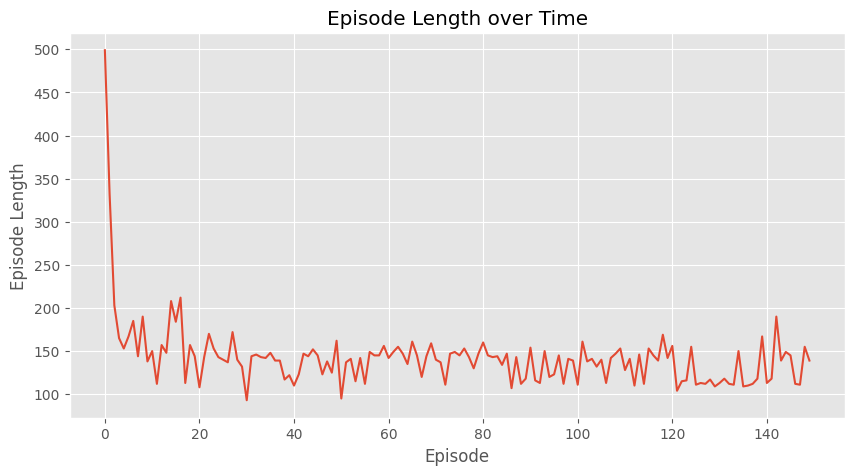

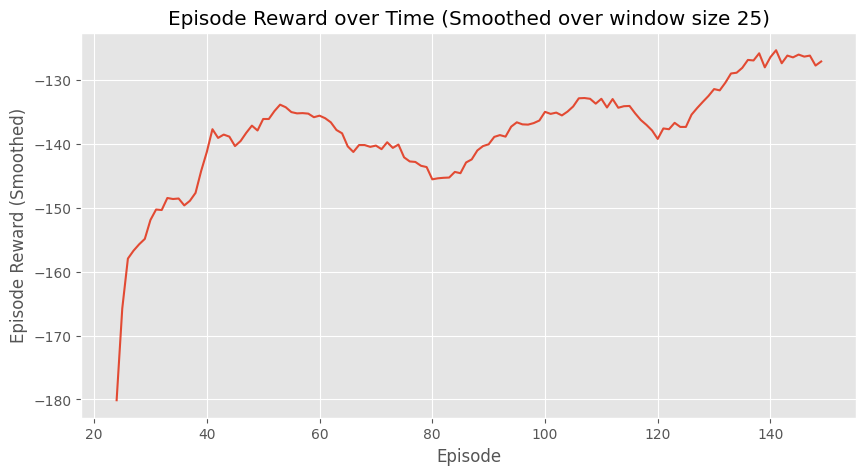

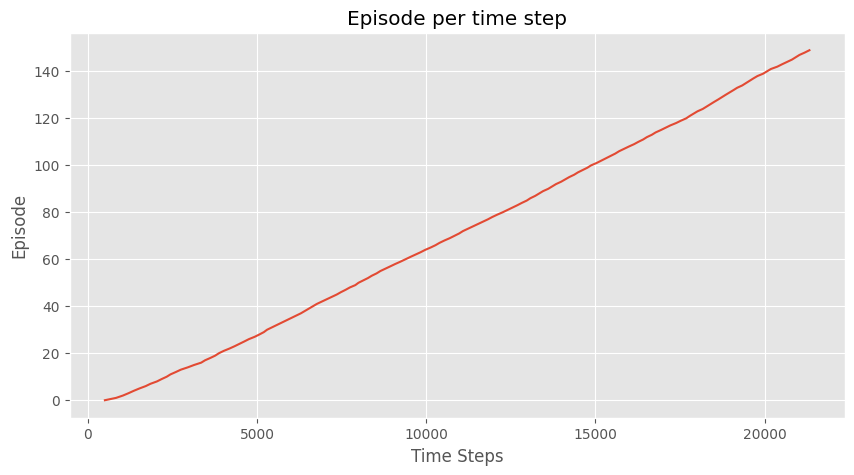

(<Figure size 1000x500 with 1 Axes>,
 <Figure size 1000x500 with 1 Axes>,
 <Figure size 1000x500 with 1 Axes>)

In [ ]:
plotting.plot_episode_stats(stats, smoothing_window=25)

## Run the Optimal Policy

In [ ]:
import matplotlib.pyplot as plt
import numpy as np


state = env.reset()
fig, ax = plt.subplots()
frame = env.render()
im = ax.imshow(frame[0])
ims = [[im]]

while(True):
    q_values = estimator.predict(state)
    best_action = np.argmax(q_values)
    next_state, reward, end, _ = env.step(best_action)
    frame = env.render()
    im = ax.imshow(frame[0])
    ims.append([im])
    if end:
        break
    state = next_state

ani = animation.ArtistAnimation(fig, ims, interval=50, blit=True,
                                repeat_delay=1000)

plt.close()
HTML(ani.to_jshtml())
